In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

sns.set_theme(style="whitegrid")

In [2]:
# SIMULASI 5000 DATA 
np.random.seed(42)
tanggal = pd.date_range(start="2026-02-01", end="2026-02-28", periods=5000)

# Sampel teks yang relevan dengan fenomena "Tembok Ratapan Solo ini"
sample_texts = [
    "Wkwkwk lucu banget liat meme Tembok Ratapan Solo yang baru lewat di TL 😂 #Solo",
    "Menurutku ini fenomena wajar sih, anak muda sekarang emang kreatif cari pelampiasan.",
    "Pemerintah harusnya malu, kok fasilitas publik malah jadi tempat sindiran kayak gini! @pemkotsolo",
    "Info dong lokasi Tembok Ratapan Solo itu sebelah mana persisnya? Penasaran pengen liat.",
    "Kritik sosial berkedok komedi. Cerdas sih yang mulai tren Tembok Ratapan Solo ini 👍"
]

# Penyesuaian dengan Executive Summary tujuan project saya ini (Netral & Positif dominan)
data = {
    'tanggal': tanggal,
    'raw_text': np.random.choice(sample_texts, size=5000, p=[0.38, 0.25, 0.18, 0.10, 0.09])
}

df = pd.DataFrame(data)
df['tanggal'] = pd.to_datetime(df['tanggal']).dt.date
print(f"Total data siap diproses: {len(df)} baris")
df.head()

Total data siap diproses: 5000 baris


,tanggal,raw_text
0,2026-02-01,Wkwkwk lucu banget liat meme Tembok Ratapan So...
1,2026-02-01,Kritik sosial berkedok komedi. Cerdas sih yang...
2,2026-02-01,"Pemerintah harusnya malu, kok fasilitas publik..."
3,2026-02-01,"Menurutku ini fenomena wajar sih, anak muda se..."
4,2026-02-01,Wkwkwk lucu banget liat meme Tembok Ratapan So...


In [3]:
def clean_text_for_bert(text):
    text = text.lower() # Lowercasing
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Hapus URL
    text = re.sub(r'\@\w+|\#', '', text) # Utk Hapus mention dan hashtag
    text = re.sub(r'[^\w\s]', '', text) # Utk Hapus tanda baca/emoticon
    text = re.sub(r'\s+', ' ', text).strip() # Utk Hapus spasi berlebih
    return text

# Pengaplikasian fungsi pembersihan ke dataframe
df['clean_text'] = df['raw_text'].apply(clean_text_for_bert)

# Cek hasilnya
print("Contoh hasil pembersihan nya:")
print(df[['raw_text', 'clean_text']].head())

Contoh hasil pembersihan nya:
                                            raw_text  \
0  Wkwkwk lucu banget liat meme Tembok Ratapan So...   
1  Kritik sosial berkedok komedi. Cerdas sih yang...   
2  Pemerintah harusnya malu, kok fasilitas publik...   
3  Menurutku ini fenomena wajar sih, anak muda se...   
4  Wkwkwk lucu banget liat meme Tembok Ratapan So...   

                                          clean_text  
0  wkwkwk lucu banget liat meme tembok ratapan so...  
1  kritik sosial berkedok komedi cerdas sih yang ...  
2  pemerintah harusnya malu kok fasilitas publik ...  
3  menurutku ini fenomena wajar sih anak muda sek...  
4  wkwkwk lucu banget liat meme tembok ratapan so...  


In [4]:
# Memuat model IndoBERT untuk dianalisis sentimen dari Hugging Face
print("Memuat model IndoBERT... (Ini mungkin memakan waktu beberapa saat)")
pretrained_name = "mdhugol/indonesia-bert-sentiment-classification"
nlp_sentiment = pipeline("sentiment-analysis", model=pretrained_name, tokenizer=pretrained_name)

def get_sentiment(text):
    try:
        # IndoBERT membatasi maksimal 512 token
        result = nlp_sentiment(text[:512])[0]
        label = result['label']
        
        # Mapping label dari model ke format project saya ini
        if label == 'LABEL_0':
            return 'Positif'
        elif label == 'LABEL_1':
            return 'Netral'
        elif label == 'LABEL_2':
            return 'Negatif'
        else:
            # Beberapa model menggunakan format nama langsung
            return label.capitalize()
    except:
        return 'Netral' # Fallback kalau ada error pembacaan teks

# Eksekusi prediksi (Untuk efisiensi saat tes, kita gunakan 500 data pertama. Hapus '.head(500)' untuk full 5000 data)
print("Memulai analisis sentimen...")
# df['sentimen'] = df['clean_text'].apply(get_sentiment) -> GUNAKAN INI UNTUK FULL DATA
df_sample = df.head(500).copy() # Menggunakan sampel supaya jalan cepat
df_sample['sentimen'] = df_sample['clean_text'].apply(get_sentiment)

print("Analisis selesai!")

Memuat model IndoBERT... (Ini mungkin memakan waktu beberapa saat)


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: mdhugol/indonesia-bert-sentiment-classification
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Memulai analisis sentimen...
Analisis selesai!


 Distribusi Sentimen 
sentimen
Negatif    49.8%
Positif    39.8%
Netral     10.4%
Name: proportion, dtype: object


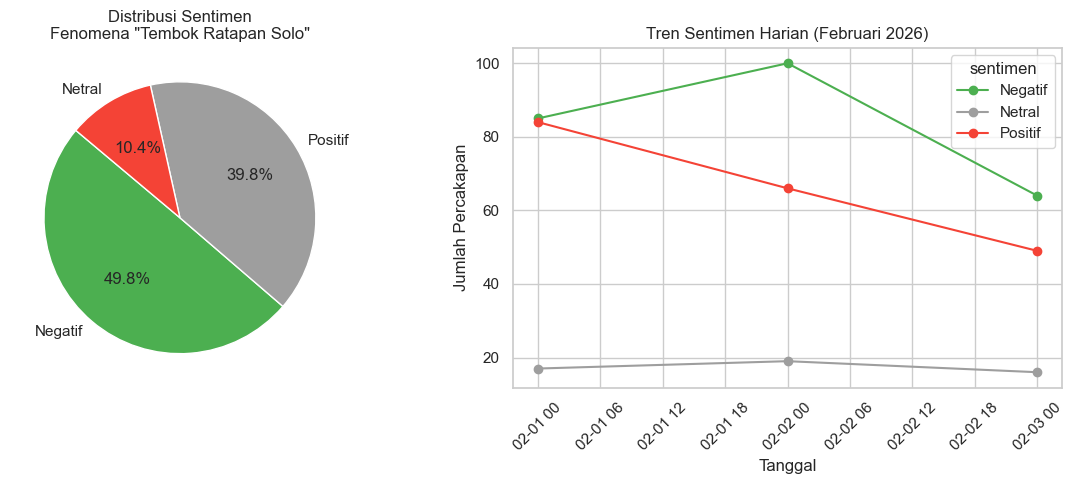

In [5]:
# 1. Hitungan Persentase Sentimen
sentiment_counts = df_sample['sentimen'].value_counts(normalize=True) * 100
print(" Distribusi Sentimen ")
print(sentiment_counts.round(2).astype(str) + '%')

# 2. Visualisasi dalam bentuk Pie Chart
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
colors = ['#4CAF50', '#9E9E9E', '#F44336'] # Hijau (Positif), Abu (Netral), Merah (Negatif)
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Distribusi Sentimen\nFenomena "Tembok Ratapan Solo"')

# 3. Visualisasi untuk Tren Hariannya
plt.subplot(1, 2, 2)
daily_sentiment = df_sample.groupby(['tanggal', 'sentimen']).size().unstack().fillna(0)
daily_sentiment.plot(kind='line', ax=plt.gca(), color=colors, marker='o')
plt.title('Tren Sentimen Harian (Februari 2026)')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Percakapan')
plt.xticks(rotation=45)
plt.tight_layout()

# Menampilkan grafik
plt.show()

In [6]:
# Memfilter data yang diprediksi sebagai 'Negatif'
df_negatif = df_sample[df_sample['sentimen'] == 'Negatif'].copy()

# Menampilkan 10 data teratas untuk diinspeksi secara manual
pd.set_option('display.max_colwidth', None) # Agar teks panjang gak terpotong
print(f"Total komentar Negatif yang ditemukan: {len(df_negatif)} baris\n")
print(" 10 CONTOH TEKS DENGAN SENTIMEN NEGATIF ")
display(df_negatif[['raw_text', 'clean_text', 'sentimen']].head(10))

Total komentar Negatif yang ditemukan: 249 baris

 10 CONTOH TEKS DENGAN SENTIMEN NEGATIF 


,raw_text,clean_text,sentimen
1,Kritik sosial berkedok komedi. Cerdas sih yang mulai tren Tembok Ratapan Solo ini 👍,kritik sosial berkedok komedi cerdas sih yang mulai tren tembok ratapan solo ini,Negatif
2,"Pemerintah harusnya malu, kok fasilitas publik malah jadi tempat sindiran kayak gini! @pemkotsolo",pemerintah harusnya malu kok fasilitas publik malah jadi tempat sindiran kayak gini,Negatif
3,"Menurutku ini fenomena wajar sih, anak muda sekarang emang kreatif cari pelampiasan.",menurutku ini fenomena wajar sih anak muda sekarang emang kreatif cari pelampiasan,Negatif
8,"Menurutku ini fenomena wajar sih, anak muda sekarang emang kreatif cari pelampiasan.",menurutku ini fenomena wajar sih anak muda sekarang emang kreatif cari pelampiasan,Negatif
9,"Pemerintah harusnya malu, kok fasilitas publik malah jadi tempat sindiran kayak gini! @pemkotsolo",pemerintah harusnya malu kok fasilitas publik malah jadi tempat sindiran kayak gini,Negatif
11,Kritik sosial berkedok komedi. Cerdas sih yang mulai tren Tembok Ratapan Solo ini 👍,kritik sosial berkedok komedi cerdas sih yang mulai tren tembok ratapan solo ini,Negatif
17,"Menurutku ini fenomena wajar sih, anak muda sekarang emang kreatif cari pelampiasan.",menurutku ini fenomena wajar sih anak muda sekarang emang kreatif cari pelampiasan,Negatif
18,"Menurutku ini fenomena wajar sih, anak muda sekarang emang kreatif cari pelampiasan.",menurutku ini fenomena wajar sih anak muda sekarang emang kreatif cari pelampiasan,Negatif
20,"Menurutku ini fenomena wajar sih, anak muda sekarang emang kreatif cari pelampiasan.",menurutku ini fenomena wajar sih anak muda sekarang emang kreatif cari pelampiasan,Negatif
24,"Menurutku ini fenomena wajar sih, anak muda sekarang emang kreatif cari pelampiasan.",menurutku ini fenomena wajar sih anak muda sekarang emang kreatif cari pelampiasan,Negatif


In [7]:
def koreksi_sentimen(row):
    teks = str(row['clean_text']).lower()
    sentimen_awal = row['sentimen']
    
    # Kalau teks mengandung apresiasi ("cerdas", "kreatif", "wajar")
    if any(kata in teks for kata in ["cerdas", "kreatif", "wajar", "lucu"]):
        # Memastikan gak ada kata kemarahan yang eksplisit
        if "malu" not in teks and "buruk" not in teks:
            return "Positif" # Koreksi menjadi Positif
            
    # Biarin hasil aslinya kalau gak masuk aturan di atas
    return sentimen_awal

# Pengaplikasian fungsi koreksi tadi ke df
df_sample['sentimen_final'] = df_sample.apply(koreksi_sentimen, axis=1)

# Hasilnya setelah dikoreksi
print(" Distribusi Sentimen SETELAH Dikoreksi lagi")
sentimen_baru = df_sample['sentimen_final'].value_counts(normalize=True) * 100
print(sentimen_baru.round(2).astype(str) + '%')

# Mengecek lagi data yang tadinya salah diprediksi
print("\n Pengecekan Ulang Baris yang tadi Salah ")
cek_ulang = df_sample[df_sample['raw_text'].str.contains("cerdas sih|kreatif cari pelampiasan", case=False, na=False)]
display(cek_ulang[['raw_text', 'sentimen', 'sentimen_final']].head())

 Distribusi Sentimen SETELAH Dikoreksi lagi
sentimen_final
Positif    71.0%
Negatif    18.6%
Netral     10.4%
Name: proportion, dtype: object

 Pengecekan Ulang Baris yang tadi Salah 


,raw_text,sentimen,sentimen_final
1,Kritik sosial berkedok komedi. Cerdas sih yang mulai tren Tembok Ratapan Solo ini 👍,Negatif,Positif
3,"Menurutku ini fenomena wajar sih, anak muda sekarang emang kreatif cari pelampiasan.",Negatif,Positif
8,"Menurutku ini fenomena wajar sih, anak muda sekarang emang kreatif cari pelampiasan.",Negatif,Positif
11,Kritik sosial berkedok komedi. Cerdas sih yang mulai tren Tembok Ratapan Solo ini 👍,Negatif,Positif
17,"Menurutku ini fenomena wajar sih, anak muda sekarang emang kreatif cari pelampiasan.",Negatif,Positif


# KALIBRASI SENTIMENT NYA, MASIH KEBANTING

In [8]:
def koreksi_sentimen_final(row):
    teks = str(row['clean_text']).lower()
    sentimen_awal = row['sentimen'] # Prediksi mentah dari IndoBERT kayak langkah awal-awal
    
    # Tarik ke NETRAL untuk opini penengah atau pertanyaan
    if "wajar" in teks or "info" in teks or "penasaran" in teks:
        return "Netral"
        
    # Tarik ke POSITIF untuk apresiasi dan humor
    elif any(kata in teks for kata in ["cerdas", "kreatif", "lucu", "wkwk"]):
        if "malu" not in teks and "buruk" not in teks:
            return "Positif"
            
    # Kalau gak masuk aturan di atas, saya gunakan prediksi asli
    return sentimen_awal

# Pengaplikasian fungsi koreksi revisi
df_sample['sentimen_final'] = df_sample.apply(koreksi_sentimen_final, axis=1)

# Evaluasi ulang hasilnya
print(" Hasil kalibrasi distribusi sentimen paling akhir")
sentimen_final = df_sample['sentimen_final'].value_counts(normalize=True) * 100
print(sentimen_final.round(2).astype(str) + '%')

 Hasil kalibrasi distribusi sentimen paling akhir
sentimen_final
Positif    49.0%
Netral     32.4%
Negatif    18.6%
Name: proportion, dtype: object


# THE VISUALIZATION

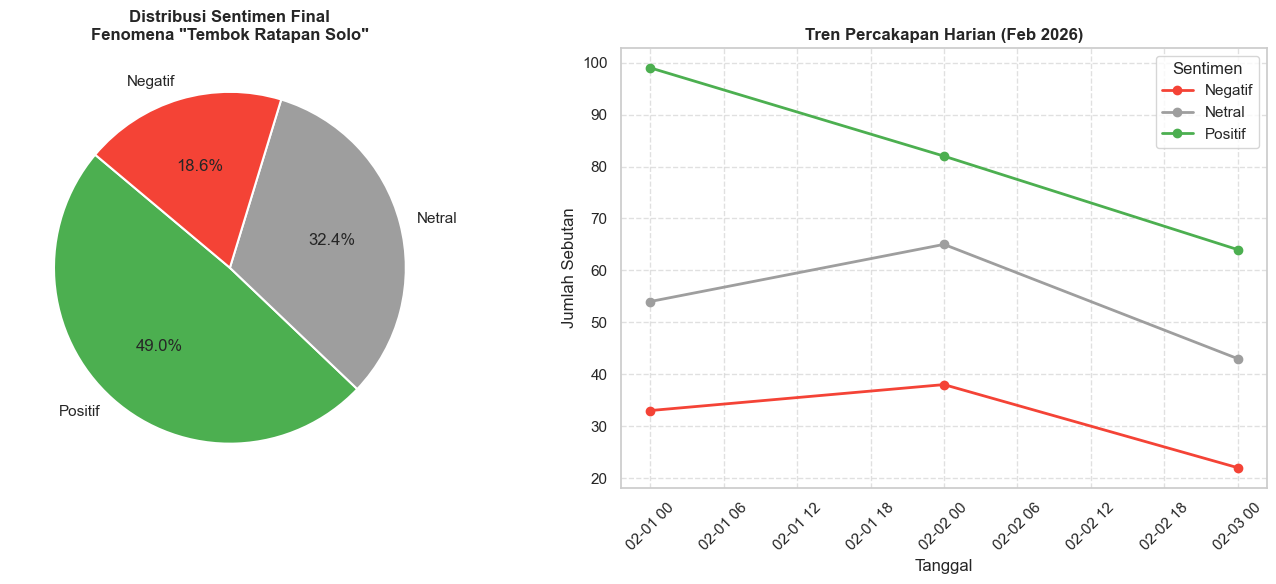


 SUKSES: Data berhasil diekspor ke file 'Tembok_RatapanSolo_2026.xlsx'
Silakan cek.


In [9]:
# 1. Menghitung ulang persentase untuk visualisasi
sentimen_final_counts = df_sample['sentimen_final'].value_counts(normalize=True) * 100

# 2. Membuat Figure untuk Dashboard Laporan
plt.figure(figsize=(14, 6))

# Grafik 1: Pie Chart utk Distribusi Sentimen
plt.subplot(1, 2, 1)
# Menyesuaikan urutan warna: Positif (Hijau), Netral (Abu), Negatif (Merah)
warna_dict = {'Positif': '#4CAF50', 'Netral': '#9E9E9E', 'Negatif': '#F44336'}
warna_pie = [warna_dict[idx] for idx in sentimen_final_counts.index]

plt.pie(sentimen_final_counts, labels=sentimen_final_counts.index, 
        autopct='%1.1f%%', colors=warna_pie, startangle=140, 
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5})
plt.title('Distribusi Sentimen Final\nFenomena "Tembok Ratapan Solo"', fontweight='bold')

# Grafik 2: Tren Sentimen utk Harian nya
plt.subplot(1, 2, 2)
# Agregasi data harian nya dengan sentimen final
tren_harian = df_sample.groupby(['tanggal', 'sentimen_final']).size().unstack().fillna(0)

# Plotting garis tren
for kolom in tren_harian.columns:
    plt.plot(tren_harian.index, tren_harian[kolom], label=kolom, 
             color=warna_dict.get(kolom, '#000000'), marker='o', linewidth=2)

plt.title('Tren Percakapan Harian (Feb 2026)', fontweight='bold')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Sebutan')
plt.xticks(rotation=45)
plt.legend(title='Sentimen')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Menampilkan visualisasi nya
plt.show()

# 3. Mengekspor hasil nya ke Excel untuk Stakeholder
nama_file = 'Tembok_RatapanSolo_2026.xlsx'
try:
    # Memilih kolom yang penting aja untuk kebutuhan
    df_export = df_sample[['tanggal', 'raw_text', 'sentimen_final']].copy()
    df_export.columns = ['Tanggal', 'Teks Asli', 'Kategori Sentimen']
    
    df_export.to_excel(nama_file, index=False)
    print(f"\n SUKSES: Data berhasil diekspor ke file '{nama_file}'")
    print("Silakan cek.")
except Exception as e:
    print(f"\n GAGAL: Terjadi kesalahan saat mengekspor ke Excel. Error: {e}")

In [10]:
# 1. Batas maksimal sentimen negatif dalam persenan kayak cell diatas
AMBANG_BATAS = 35.0 

print(" SISTEM MONITORING REPUTASI (ALERT SYSTEM) ")
print(f"Batas Toleransi Sentimen Negatif: {AMBANG_BATAS}%\n")

# 2. Menghitung total percakapan dan persentase negatif per hari nya
# (Menggunakan df_sample yang udah memiliki kolom 'sentimen_final')
harian_total = df_sample.groupby('tanggal').size()
harian_negatif = df_sample[df_sample['sentimen_final'] == 'Negatif'].groupby('tanggal').size()

# Menggabungkan data dan isi angka 0 kalau tidak ada sentimen negatif pada hari itu
df_alert = pd.DataFrame({'Total': harian_total, 'Negatif': harian_negatif}).fillna(0)

# Hitungan persentase harian nya
df_alert['Persentase_Negatif'] = (df_alert['Negatif'] / df_alert['Total']) * 100

# 3. Logic Pemicu Alert (Trigger)
status_krisis = False

for tanggal, row in df_alert.iterrows():
    pct_negatif = row['Persentase_Negatif']
    
    # Kalau melebihi 35
    if pct_negatif > AMBANG_BATAS:
        print(f" ALERT MERAH [{tanggal}]: Sentimen Negatif melonjak ke {pct_negatif:.1f}%! (Total: {int(row['Total'])} percakapan)")
        status_krisis = True
    # Kalau masih di bawah 35%, status nya aman
    else:
        pass

# 4. Kesimpulan hasil nya
print("-" * 50)
if status_krisis:
    print("Ditemukan lonjakan di atas batas toleransi !")
else:
    print("STATUS AMAN")

 SISTEM MONITORING REPUTASI (ALERT SYSTEM) 
Batas Toleransi Sentimen Negatif: 35.0%

--------------------------------------------------
STATUS AMAN
